In [24]:
from __future__ import division
import os
import numpy as np
import pandas as pd
import pretty_midi
import librosa, librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

from global_config import *

## Example of dealing with midi data

In [107]:
hop_length = 10/1000*SR
example_filename = '2002/kolessova07'
midi_path = os.path.join(DIR_RENDERED, '{}.mid'.format(example_filename))
paudio_path = os.path.join(DIR_RENDERED, '{}-p.wav'.format(example_filename))
py, _ = librosa.load(paudio_path, sr=SR)
pcqt = librosa.cqt(py, sr=SR)

# get ground truth pedal onset time from midi
pm = pretty_midi.PrettyMIDI(midi_path)
pedal_v = []
pedal_t = []
for control_change in pm.instruments[0].control_changes:
    if control_change.number == 64:
        pedal_v.append(control_change.value)
        pedal_t.append(control_change.time)

pedal_onset = []
pedal_offset = []
for i,v in enumerate(pedal_v):
    if i>0 and v>=64 and pedal_v[i-1]<64:
        pedal_onset.append(pedal_t[i])   
    elif i>0 and v<64 and pedal_v[i-1]>=64:
        pedal_offset.append(pedal_t[i])

pedal_offset = [t for t in pedal_offset if t > pedal_onset[0]]
seg_idxs = np.min([len(pedal_onset), len(pedal_offset)])
pedal_offset = pedal_offset[:seg_idxs]
pedal_onset = pedal_onset[:seg_idxs]
for seg_idx, offset in enumerate(pedal_offset):
    if offset != pedal_offset[-1] and offset > pedal_onset[seg_idx] and offset < pedal_onset[seg_idx+1]:
        correct_pedal_data = True
    elif offset == pedal_offset[-1] and offset > pedal_onset[seg_idx]:
        correct_pedal_data = True
    else:
        correct_pedal_data = False

if correct_pedal_data:
    print("Got the pedal data from midi!")
else:
    print("Oops! There are something wrong with the midi data.")

In [108]:
def plot_piano_roll(midi_data, start_pitch, end_pitch, fs=100):
    librosa.display.specshow(midi_data.get_piano_roll(fs)[start_pitch:end_pitch],
                            hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                            fmin=pretty_midi.note_number_to_hz(start_pitch))

Text(0.5,1,u'constant-q power spectrum')

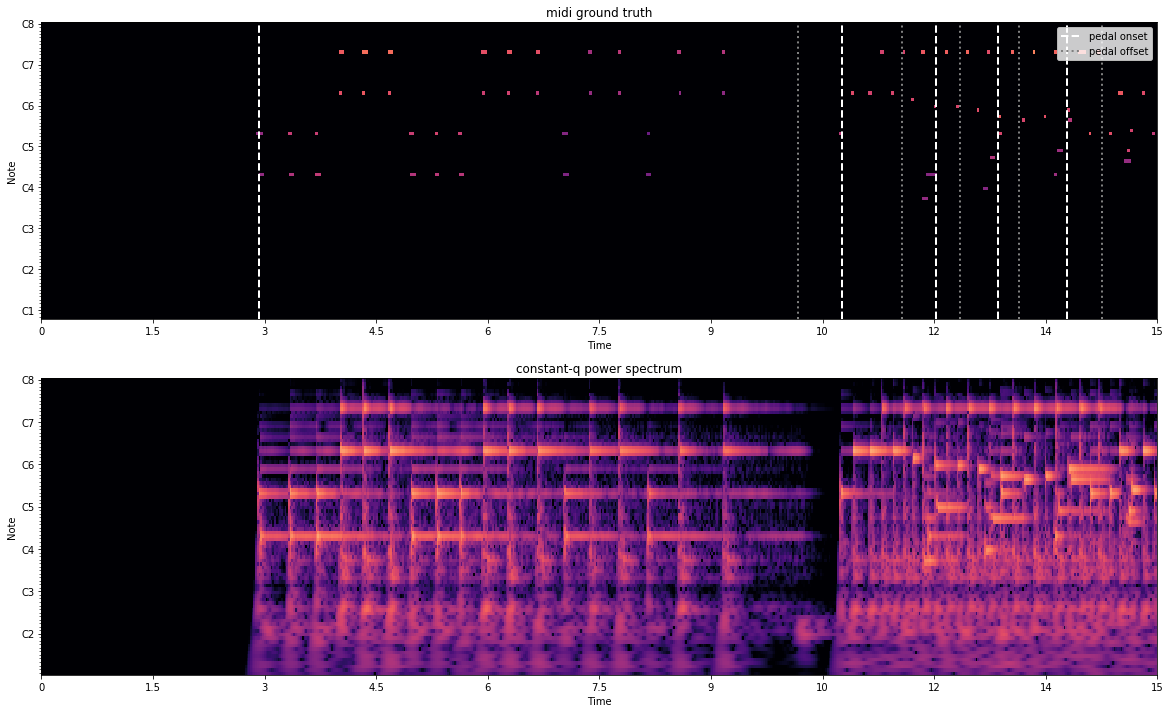

In [109]:
plt.figure(figsize=(20,12))
xlim_left, xlim_right = [0,15]

ax1 = plt.subplot(2,1,1)
plot_piano_roll(pm,21,108)
ymin,ymax = plt.ylim()
plt.vlines(pedal_onset, ymin, ymax, linestyle='dashed', lw=2, color='white',label='pedal onset')
plt.vlines(pedal_offset, ymin, ymax, linestyle='dotted', lw=2, color='grey',label='pedal offset')
plt.xlim(xlim_left, xlim_right)
plt.legend()
plt.title('midi ground truth')

ax2 = plt.subplot(2,1,2, sharex=ax1)
librosa.display.specshow(librosa.amplitude_to_db(pcqt, ref=np.max),sr=sr,x_axis='time',y_axis='cqt_note')
plt.xlim(xlim_left, xlim_right)
plt.title('constant-q power spectrum')

## Get the pedal onset and offset times from the midi files in train/valid/test split

In [20]:
def write_to_csv(rows, column_names, csv_fname):
    df = pd.DataFrame(rows, columns=column_names)
    df.to_csv(os.path.join(DIR_PEDAL_METADATA, csv_fname))
    
    
for split in ['train', 'valid', 'test']:

    filenames = []
    pedal_onsets = []
    pedal_offsets = []
    filename_list = np.loadtxt(os.path.join(DIR_PEDAL_METADATA, '{}.txt'.format(split)), dtype=str)
    for filename in filename_list:  
        midi_path = os.path.join(DIR_RENDERED, '{}.mid'.format(filename))

        # get ground truth pedal onset time from midi
        pm = pretty_midi.PrettyMIDI(midi_path)
        pedal_v = []
        pedal_t = []
        for control_change in pm.instruments[0].control_changes:
            if control_change.number == 64:
                pedal_v.append(control_change.value)
                pedal_t.append(control_change.time)

        pedal_onset = []
        pedal_offset = []
        for i,v in enumerate(pedal_v):
            if i>0 and v>=64 and pedal_v[i-1]<64:
                pedal_onset.append(pedal_t[i])   
            elif i>0 and v<64 and pedal_v[i-1]>=64:
                pedal_offset.append(pedal_t[i])

        pedal_offset = [t for t in pedal_offset if t > pedal_onset[0]]
        seg_idxs = np.min([len(pedal_onset), len(pedal_offset)])
        pedal_offset = pedal_offset[:seg_idxs]
        pedal_onset = pedal_onset[:seg_idxs]
        for seg_idx, offset in enumerate(pedal_offset):
            if offset != pedal_offset[-1] and offset > pedal_onset[seg_idx] and offset < pedal_onset[seg_idx+1]:
                correct_pedal_data = True
            elif offset == pedal_offset[-1] and offset > pedal_onset[seg_idx]:
                correct_pedal_data = True
            else:
                correct_pedal_data = False

        if correct_pedal_data:
            filenames.append(filename)
            pedal_onsets.append(pedal_onset)
            pedal_offsets.append(pedal_offset)


    np.savez(os.path.join(DIR_PEDAL_METADATA, 'pedal-times_{}.npz'.format(split)), 
             filename=filenames, pedal_onset=pedal_onsets, pedal_offset=pedal_offsets)
    print('pedal-times_{}.npz is saved!'.format(split))

pedal-times_test.npz is saved!


## Pedal times were saved in npz files, which can be loaded by:

In [21]:
npz_path = os.path.join(DIR_PEDAL_METADATA, 'pedal-times_test.npz')
tracks = np.load(npz_path)